# LSTM REGRESSSION MODEL
      

In [43]:
# Importing Libraries
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
import warnings
warnings.filterwarnings('ignore')

In [4]:
# from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import mlflow

In [5]:
#importing local modules
#from scripts.ML_modelling_utils import *
sys.path.append(os.path.abspath(os.path.join('data')))
sys.path.insert(0,'../scripts/')
from Results import result_picker
from data_manipulation import DataManipulator
from data_information import DataInfo
from cleaner import DataCleaner
import mlflow
sns.set()

results = result_picker()

## Loading Data

In [6]:
clean_df = pd.read_csv('../data/cleaner.csv')
clean_df = clean_df[['Date','Sales']]
clean_df = clean_df.groupby('Date').agg({'Sales':'mean'})

## Scaling

In [7]:
manipulator = DataManipulator(clean_df, deep=True)

In [8]:
#scaling all numeric values of the sales column b/n range of -1 to 1
manipulator.minmax_scale_columns(['Sales'], range_tup=(-1,1))

,Sales
Date,
2013-01-01,-1.000000
2013-01-02,-0.117299
2013-01-03,-0.194846
2013-01-04,-0.157344
2013-01-05,-0.245886
...,...
2015-07-27,0.366716
2015-07-28,0.161615
2015-07-29,0.082380


In [9]:
#create a data cleaner object 
cleaner = DataCleaner(clean_df)
scaled_df = cleaner.optimize_df()

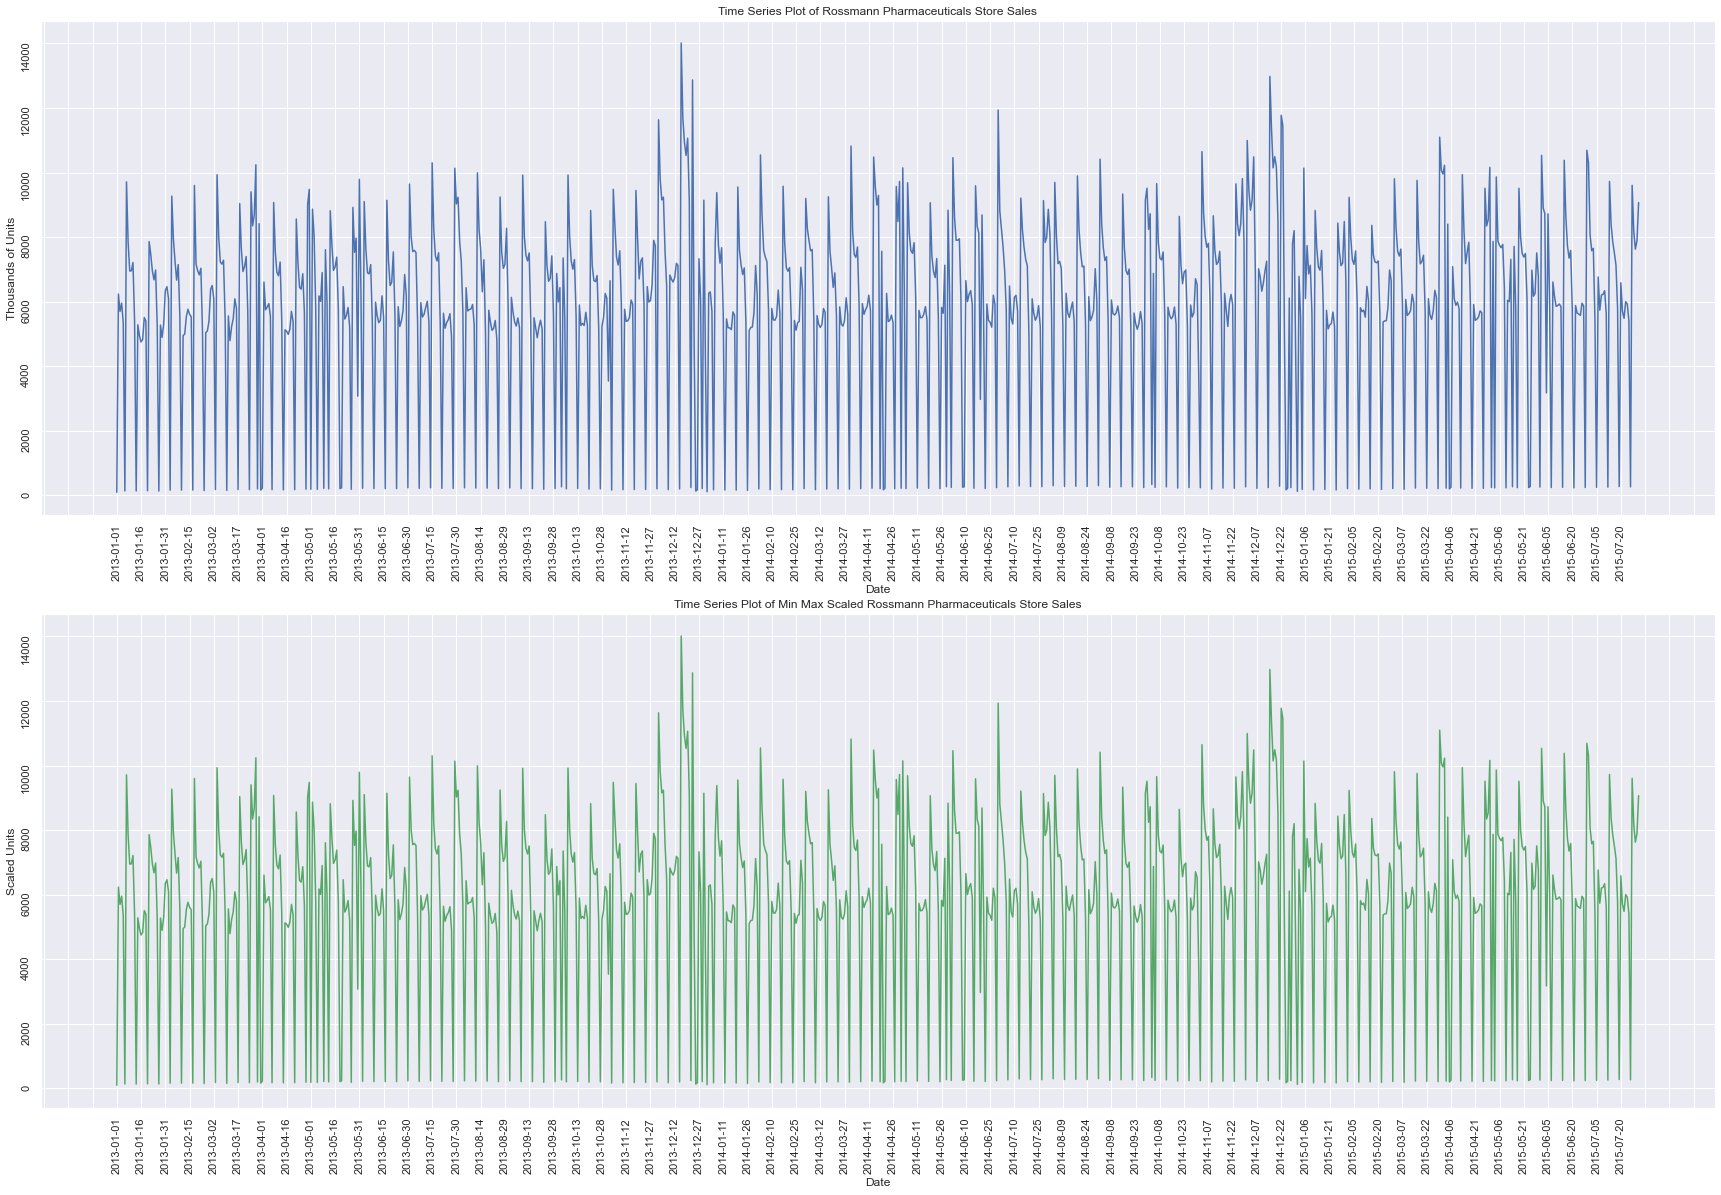

In [10]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

#creating ticks object with M ticks
M = 100 
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(clean_df.index, clean_df.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Rossmann Pharmaceuticals Store Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(scaled_df.index, scaled_df.Sales, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text(
    'Time Series Plot of Min Max Scaled Rossmann Pharmaceuticals Store Sales')
ax2.grid(True)
plt.show()

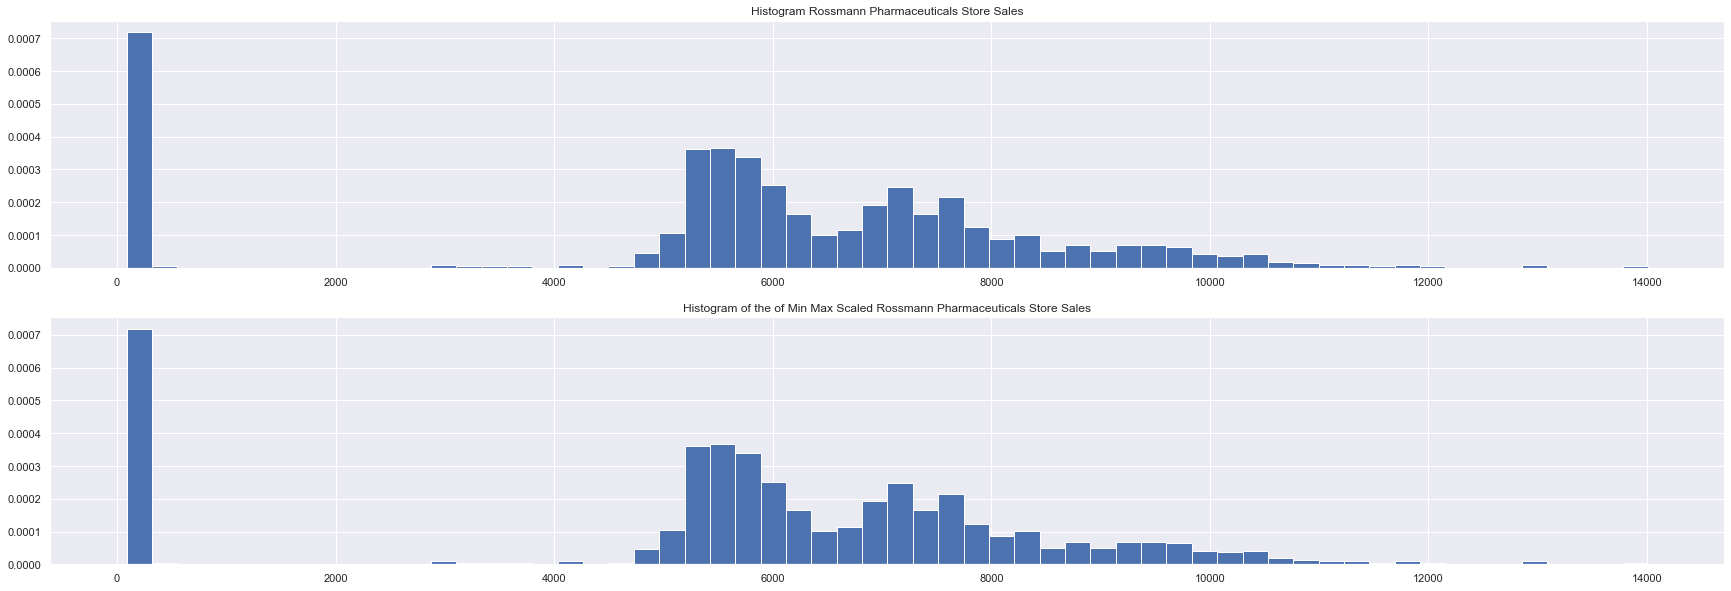

In [11]:
#ploting histogram
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(clean_df.Sales, density=True, bins=60)
ax1.title.set_text('Histogram Rossmann Pharmaceuticals Store Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(scaled_df.Sales, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled Rossmann Pharmaceuticals Store Sales')
ax2.grid(True)
plt.show()

In [12]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   942 non-null    float32
dtypes: float32(1)
memory usage: 11.0+ KB


In [14]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


In [15]:
sales_difference = difference(scaled_df.Sales.values)

In [16]:
#Check for autocorrelation and partial autocorrelation of your data
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(
        f"{prefix}  Autocorrelations of Scaled Rossmann Pharmaceuticals Store Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

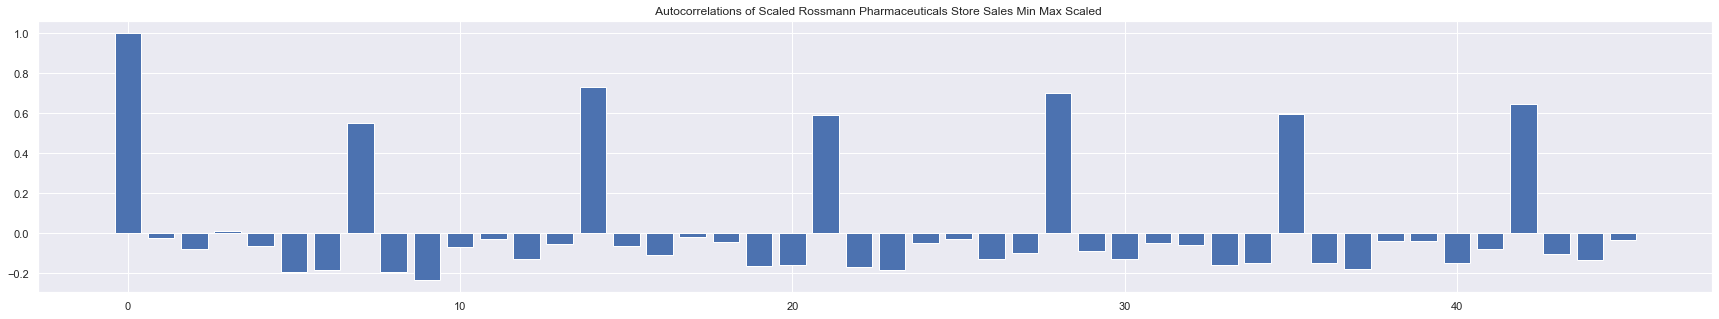

In [17]:
# AutoCorrelation
acfSalesScaled = acf(scaled_df.Sales.values, fft=True, nlags=45)
acfSalesScaledNp = np.array(acfSalesScaled)
corrPlots(acfSalesScaledNp, '')

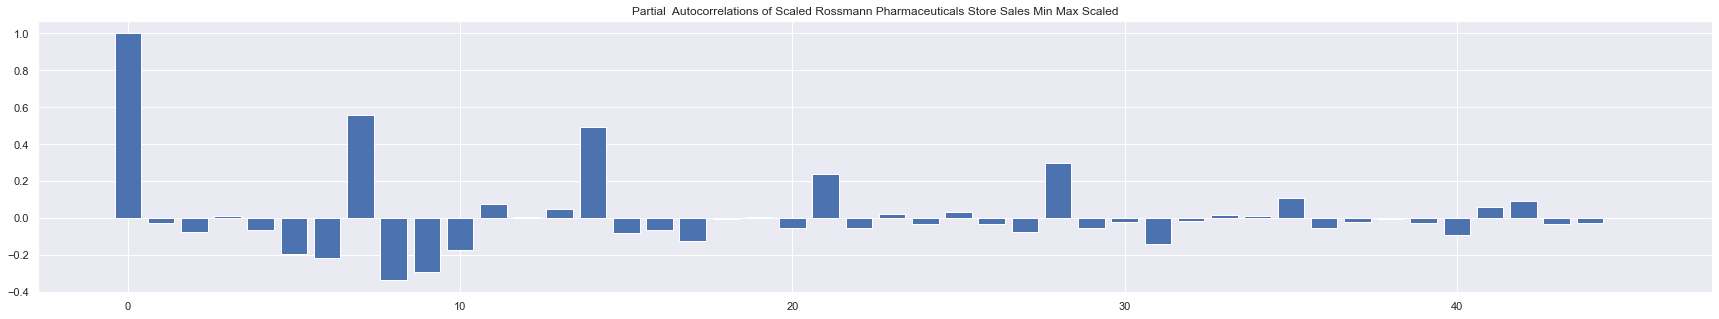

In [18]:
# Partial Correlation
pacfSalesScaled = pacf(scaled_df.Sales.values, nlags=45)
pacfSalesScaledNp = np.array(pacfSalesScaled)

corrPlots(pacfSalesScaledNp, "Partial")

# Model Prepraration

In [19]:
# Set window of past points for LSTM Model
# 6 Weeks is 45 Days (We have daily data of stores)
SIZE = len(scaled_df.Sales)
WINDOW_SIZE = 45
BATCH_SIZE = SIZE-WINDOW_SIZE*2
EPOCHS = 1000

In [20]:
# Spliting Data to Train and Test (80/20)
DateTrain = scaled_df.index.values[0:BATCH_SIZE]
DateTest = scaled_df.index.values[BATCH_SIZE:]
XTrain = scaled_df.Sales.values[0:BATCH_SIZE].astype('float32')
XTest = scaled_df.Sales.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateTest = np.reshape(DateTest, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the Testing set date series: ", DateTest.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the Testing set logarithm of sales series in a stateless LSTM: ", XTest.shape)

Shape of the training set date series:  (852, 1)
Shape of the Testing set date series:  (90, 1)

Shape of the training set logarithm of sales series:  (852,)
Shape of the Testing set logarithm of sales series in a stateless LSTM:  (90,)


In [21]:
tf.random.set_seed(0)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([852, 1])

In [22]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [23]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)

In [24]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [25]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [26]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [27]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [28]:
DatasetTrain = windowed_dataset(XTrain)
DatasetTest = windowed_dataset(XTest)

In [29]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')

In [32]:
history = model.fit(DatasetTrain, epochs=EPOCHS,
                    validation_data=DatasetTest, verbose=0)

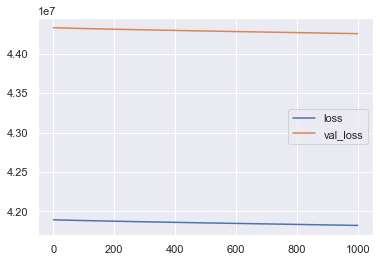

In [33]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [34]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

# Data Preparation

In [35]:
window = 45

# # Split 80/20 into train/test data
last = int(len(scaled_df.Sales)/5.0)
Xtrain = scaled_df.Sales[:-last]
Xtest = scaled_df.Sales[-last-window:]

# # Store window number of points as a sequence
xin = []
next_X = []
for i in range(window, len(Xtrain)):
    try:
        xin.append(Xtrain[i-window:i])
        next_X.append(Xtrain[i])
    except Exception as e:
        print(f'i value : {i}')
        exit(0)

# Reshape data to format for LSTM
xin, next_X = np.array(xin), np.array(next_X)
xin = xin.reshape(xin.shape[0], xin.shape[1], 1)

In [36]:
# Initialize LSTM model
m = Sequential()
m.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1], 1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [39]:
#training
# Fit LSTM model
history = m.fit(xin, next_X, epochs=200, batch_size=20, verbose=0)

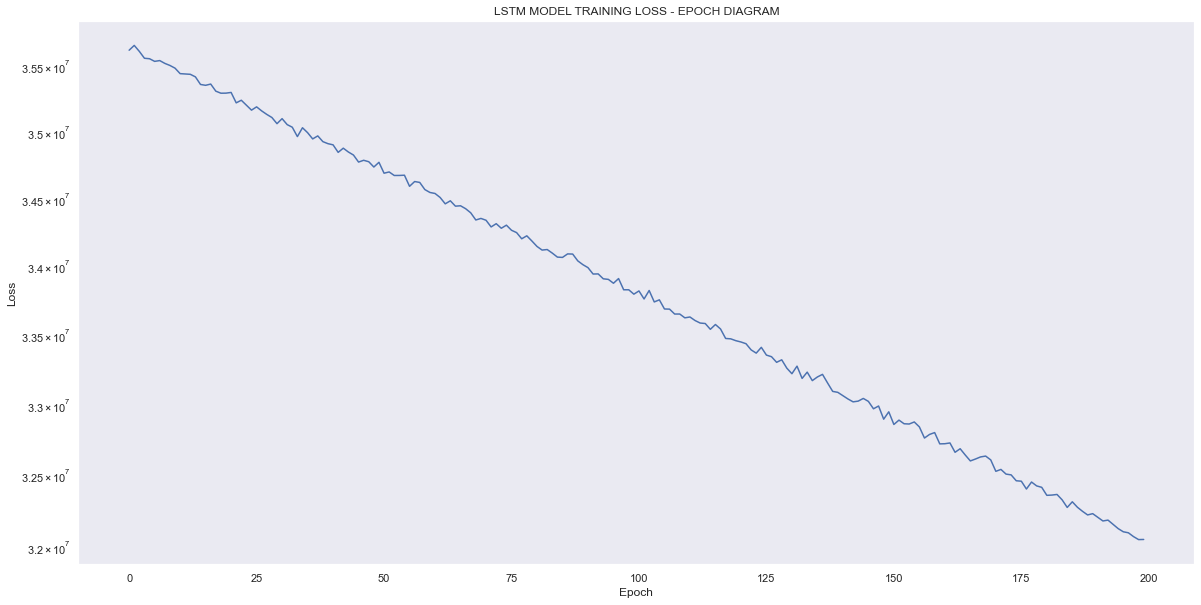

In [40]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.title('LSTM MODEL TRAINING LOSS - EPOCH DIAGRAM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.semilogy(history.history['loss'])

In [41]:
history.history['loss'][-1]

32052388.0

# Prediction

6/6 [==============================] - 0s 40ms/step


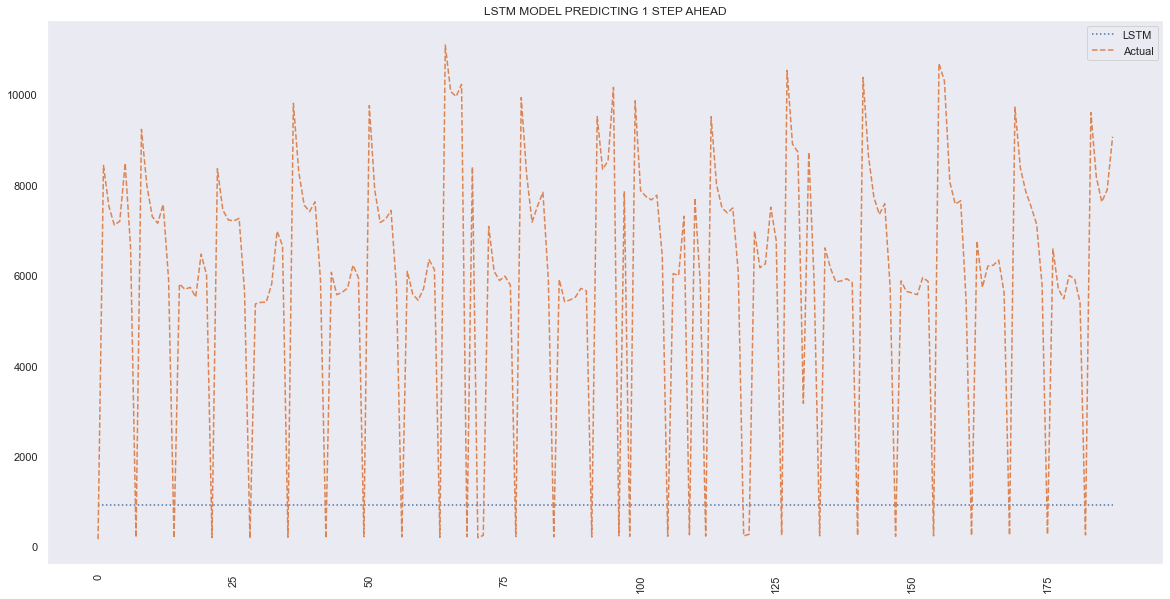

In [44]:
# Store "window" points as a sequence
xin = []
next_X1 = []
for i in range(window, len(Xtest)):
    xin.append(Xtest[i-window:i])
    next_X1.append(Xtest[i])

# Reshape data to format for LSTM
xin, next_X1 = np.array(xin), np.array(next_X1)
xin = xin.reshape((xin.shape[0], xin.shape[1], 1))

# Predict the next value (1 step ahead)
X_pred = m.predict(xin)

# Plot prediction vs actual for test data
plt.figure(figsize=(20, 10))
plt.title('LSTM MODEL PREDICTING 1 STEP AHEAD')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred, ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()

# Validation

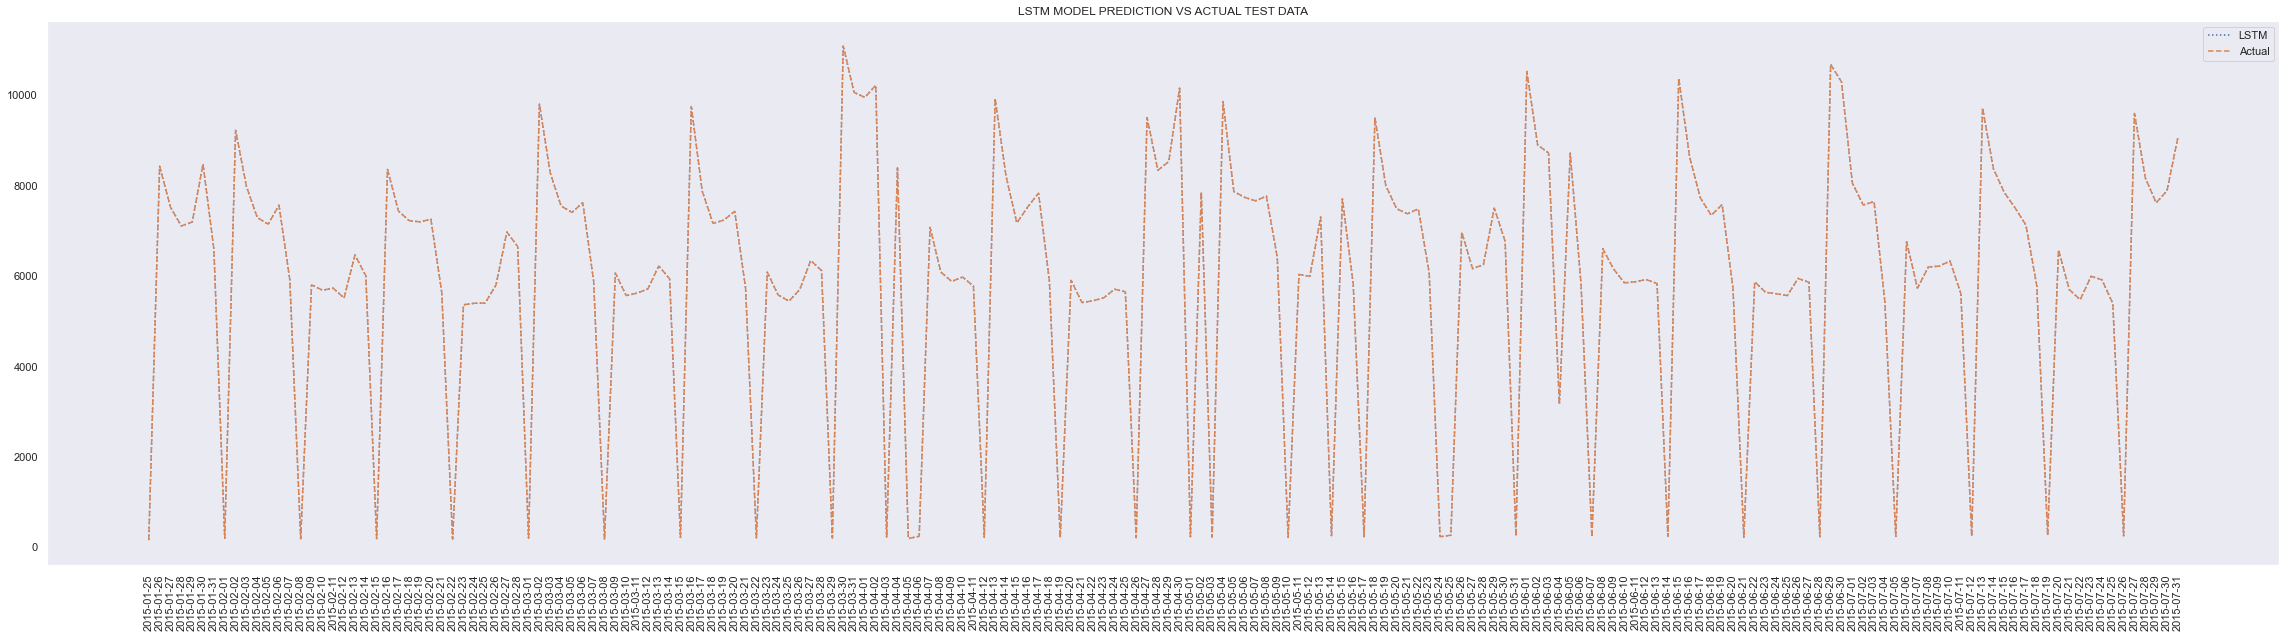

In [47]:
# Using predicted values to predict next step
X_pred = Xtest.copy()

# Plot prediction vs actual for test data
plt.figure(figsize=(40,10))
plt.title('LSTM MODEL PREDICTION VS ACTUAL TEST DATA')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred[window:], ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()

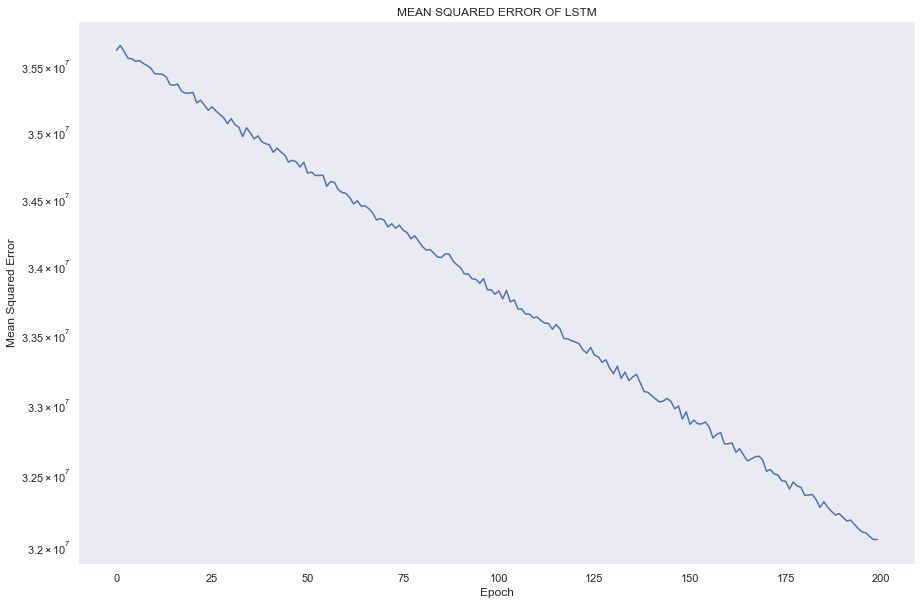

In [48]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN SQUARED ERROR OF LSTM')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mse'])

In [49]:
history.history['mse'][-1]

32052388.0

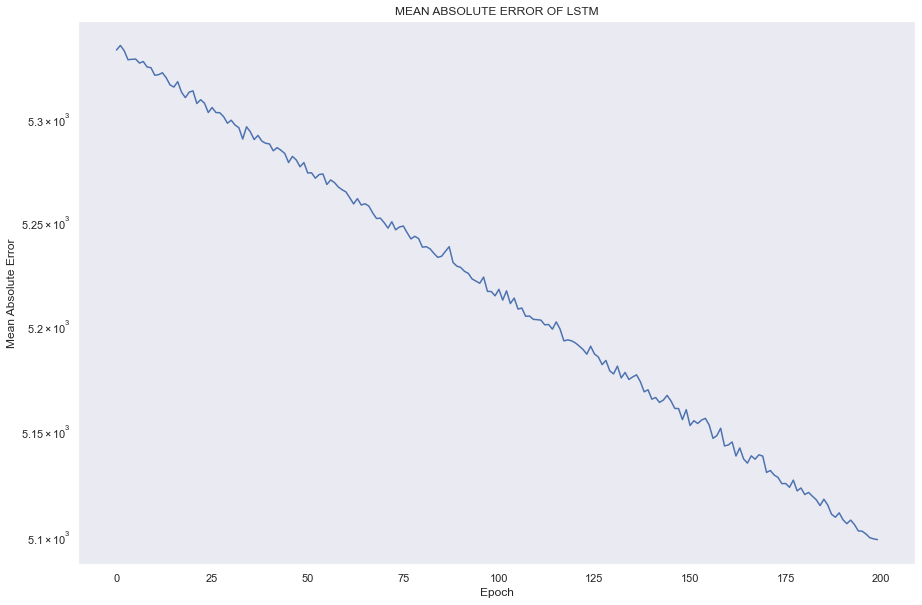

In [50]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN ABSOLUTE ERROR OF LSTM')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mae'])